# Structural Covariance Network Analysis

`scona` is a tool to perform network analysis over structural covariance networks of brain regions.

This tutorial will go through the basic functionality of `scona`, taking us from our inputs (a matrix of structural regional measures over subjects) to a report of local network measures for each brain region, and network level comparisons to a cohort of random graphs of the same degree. 

In [1]:
import matplotlib.pylab as plt
%matplotlib inline
import networkx as nx
import numpy as np
import seaborn as sns
sns.set(context="notebook", font_scale=1.5, style="white")
                
import scona as scn
import scona.datasets as datasets
from scona.scripts.visualisation_commands import view_corr_mat

## 0 Import your data

A `scona` analysis starts with four inputs.

* **regional_measures**: A pandas DataFrame with subjects as rows. The columns should include structural measures for each brain region, as well as any subject-wise covariates. 

* **names**: A list of names of the brain regions. This will be used to specify which columns of the **regional_measures** matrix to want to correlate over.

* **covars** *(optional)*: A list of your covariates. This will be used to specify which columns of **regional_measure** you wish to correct for. 

* **centroids**: A list of tuples representing the cartesian coordinates of brain regions. This list should be in the same order as the list of brain regions to accurately assign coordinates to regions. The coordinates are expected to obey the convention the the x=0 plane is the same plane that separates the left and right hemispheres of the brain. 

In [2]:
# Read in sample data from the NSPN WhitakerVertes PNAS 2016 paper.
df, names, covars, centroids = datasets.NSPN_WhitakerVertes_PNAS2016.import_data()

### Let's take a look at these different inputs:

`df` is the **regional_measures** file.

Each row is a participant in the study, and each column is a measure associated with that person.

`names` are the columns in the regional measures data frame that you care about.

The regional measures file can contain as many columns as you'd like. Some will be demographic measures (such as `centre`, `age_scan`, or `male`), others will be brain measures that you care about (see the **names** list below), and there can even be useless ones such as `Unnamed:` and `lh_unknown_part1` that are created as part of your preprocessing.

In [3]:
# The first 5 rows of our regional measures data frame
df.head()

,Unnamed: 0,nspn_id,occ,centre,study_primary,age_scan,sex,male,age_bin,mri_centre,...,rh_supramarginal_part5,rh_supramarginal_part6,rh_supramarginal_part7,rh_frontalpole_part1,rh_temporalpole_part1,rh_transversetemporal_part1,rh_insula_part1,rh_insula_part2,rh_insula_part3,rh_insula_part4
0,0,10356,0,Cambridge,2K_Cohort,20.761,Female,0.0,4,WBIC,...,2.592,2.841,2.318,2.486,3.526,2.638,3.308,2.583,3.188,3.089
1,1,10702,0,Cambridge,2K_Cohort,16.055,Male,1.0,2,WBIC,...,3.448,3.283,2.740,3.225,4.044,3.040,3.867,2.943,3.478,3.609
2,2,10736,0,Cambridge,2K_Cohort,14.897,Female,0.0,1,WBIC,...,3.526,3.269,3.076,3.133,3.900,2.914,3.894,2.898,3.720,3.580
3,3,10778,0,Cambridge,2K_Cohort,20.022,Female,0.0,4,WBIC,...,2.830,2.917,2.647,2.796,3.401,3.045,3.138,2.739,2.833,3.349
4,4,10794,0,Cambridge,2K_Cohort,14.656,Female,0.0,1,WBIC,...,2.689,3.294,2.820,2.539,2.151,2.734,2.791,2.935,3.538,3.403


In [4]:
# The top 10 regional names
names[:10]

['lh_bankssts_part1',
 'lh_bankssts_part2',
 'lh_caudalanteriorcingulate_part1',
 'lh_caudalmiddlefrontal_part1',
 'lh_caudalmiddlefrontal_part2',
 'lh_caudalmiddlefrontal_part3',
 'lh_caudalmiddlefrontal_part4',
 'lh_cuneus_part1',
 'lh_cuneus_part2',
 'lh_entorhinal_part1']

`centroids` are the x, y, z coordinates of the centres of each of the brain regions (listed in `names`)

In [5]:
# The centroids for the top 10 regions
centroids[:10]

[array([-56.40355 , -40.152663,   1.708876]),
 array([-53.140506, -49.843038,   8.264557]),
 array([-5.001684, 20.645903, 25.733446]),
 array([-33.265925,  20.200202,  45.347826]),
 array([-31.958115,   2.146597,  51.26911 ]),
 array([-38.795007,  12.584757,  33.278581]),
 array([-39.715079,  11.341351,  48.846438]),
 array([ -8.609127, -73.360119,  17.095238]),
 array([ -5.3042  , -87.102157,  19.323496]),
 array([-24.010774,  -5.86141 , -32.826641])]

In this case `covars` is an empty list because the analyses published by Whitaker, Vertes et al did not correct for any measures, but you *could* give it a list of column names containing information that you'd like to covary out of the correlation matrices.

A good example would be `age_scan` and `male` so lets set up that alternate covars list (`covars_age_male`) to compare the results as we go through this tutorial.

In [6]:
# Show the covars that ships with the example data set
covars

[]

In [7]:
# Create a list of covariates to check their effect
covars_age_male = ['age_scan', 'male']
covars_age_male

['age_scan', 'male']

## 1 Create a correlation matrix

### 1.0 Correct for covariates

The `scona` command `create_residuals_df` will calculate the residual variation in each of the brain regions after correcting for the covariates defined in `covars`.

We give the function the data frame (`df`) the columns that correspond to the brain regions we care about (`names`) and the list of columns we want to covary out (`covars` or `covars_age_male`).

Note that it's totally fine to pass an empty list for `covars`. In fact, that's the default behaviour! In this case the values will simply be de-meaned.

You can see the slight variations in the values when we remove the (linear) effects of age and gender (`df_res_age_male`) compared to no covariates (`df_res`).

In [8]:
df_res = scn.create_residuals_df(df, names, covars)
df_res.head()

,lh_bankssts_part1,lh_bankssts_part2,lh_caudalanteriorcingulate_part1,lh_caudalmiddlefrontal_part1,lh_caudalmiddlefrontal_part2,lh_caudalmiddlefrontal_part3,lh_caudalmiddlefrontal_part4,lh_cuneus_part1,lh_cuneus_part2,lh_entorhinal_part1,...,rh_supramarginal_part5,rh_supramarginal_part6,rh_supramarginal_part7,rh_frontalpole_part1,rh_temporalpole_part1,rh_transversetemporal_part1,rh_insula_part1,rh_insula_part2,rh_insula_part3,rh_insula_part4
0,-0.018479,-0.039867,0.038789,-0.004891,0.042484,-0.005625,-0.259031,-0.181875,-0.207344,-0.125609,...,-0.447062,-0.133609,-0.40075,-0.459313,-0.149781,-0.108094,-0.340437,-0.170906,-0.202625,-0.426625
1,0.278521,0.351133,0.485789,0.697109,0.408484,0.445375,0.383969,0.315125,0.374656,0.334391,...,0.408937,0.308391,0.02125,0.279688,0.368219,0.293906,0.218562,0.189094,0.087375,0.093375
2,0.166521,0.078133,0.368789,0.412109,0.285484,0.187375,0.569969,-0.072875,-0.077344,0.368391,...,0.486938,0.294391,0.35725,0.187688,0.224219,0.167906,0.245562,0.144094,0.329375,0.064375
3,-0.088479,-0.252867,-0.401211,-0.362891,-0.044516,-0.154625,-0.163031,0.018125,-0.261344,-0.015609,...,-0.209062,-0.057609,-0.07175,-0.149312,-0.274781,0.298906,-0.510438,-0.014906,-0.557625,-0.166625
4,0.398521,0.133133,0.128789,-0.218891,-1.001516,-0.142625,-0.759031,-0.102875,-0.565344,-1.229609,...,-0.350063,0.319391,0.10125,-0.406312,-1.524781,-0.012094,-0.857437,0.181094,0.147375,-0.112625


In [9]:
df_res_age_male = scn.create_residuals_df(df, names, covars_age_male)
df_res_age_male.head()

,lh_bankssts_part1,lh_bankssts_part2,lh_caudalanteriorcingulate_part1,lh_caudalmiddlefrontal_part1,lh_caudalmiddlefrontal_part2,lh_caudalmiddlefrontal_part3,lh_caudalmiddlefrontal_part4,lh_cuneus_part1,lh_cuneus_part2,lh_entorhinal_part1,...,rh_supramarginal_part5,rh_supramarginal_part6,rh_supramarginal_part7,rh_frontalpole_part1,rh_temporalpole_part1,rh_transversetemporal_part1,rh_insula_part1,rh_insula_part2,rh_insula_part3,rh_insula_part4
0,0.025274,-0.003981,0.027374,0.025228,0.074187,0.029106,-0.230710,-0.130956,-0.152991,-0.116274,...,-0.410957,-0.101754,-0.341866,-0.416429,-0.111078,-0.092773,-0.268904,-0.092201,-0.175387,-0.371141
1,0.213375,0.299765,0.475537,0.638720,0.351908,0.391191,0.346981,0.267490,0.333717,0.329503,...,0.396619,0.264649,-0.022727,0.242475,0.356351,0.269381,0.172197,0.113987,0.061124,0.084707
2,0.104989,0.018194,0.289503,0.320048,0.232394,0.136328,0.508007,-0.107705,-0.091255,0.343982,...,0.403674,0.193743,0.295648,0.061874,0.323898,0.104364,0.266246,0.140474,0.256400,0.034642
3,-0.057994,-0.229058,-0.421180,-0.348170,-0.023499,-0.130704,-0.146087,0.058237,-0.215594,-0.010526,...,-0.188000,-0.042452,-0.028050,-0.127689,-0.228394,0.304289,-0.445313,0.053424,-0.543017,-0.121881
4,0.332662,0.069256,0.046714,-0.315973,-1.058091,-0.197198,-0.824704,-0.141229,-0.582060,-1.255405,...,-0.438232,0.213297,0.034696,-0.539060,-1.422596,-0.078877,-0.838844,0.174091,0.070281,-0.145861


### 1.1 Create a correlation matrix

Now we're ready to create a correlation matrix.

You'll notice (above) that `df_res` doesn't contain the other measures from `df` - it only has the brain measures we're interested in. The default behaviour of `create_corrmat` is to correlate all of the columns. You can pass an optional measure (`names`) if you want to only correlate a subset of measures.

The default method of creating a correlation matrix is pearson correlation. If you'd prefer you can use any of the options implemented by pandas, which are `pearson`, `kendall`, `spearman` at time of writing.

Our correlation matrix `M` is a square pandas data frame with the rows and columns both corresponding to the `names` of the regions you're interested in. 

In [10]:
M = scn.create_corrmat(df_res)
M.head()

,lh_bankssts_part1,lh_bankssts_part2,lh_caudalanteriorcingulate_part1,lh_caudalmiddlefrontal_part1,lh_caudalmiddlefrontal_part2,lh_caudalmiddlefrontal_part3,lh_caudalmiddlefrontal_part4,lh_cuneus_part1,lh_cuneus_part2,lh_entorhinal_part1,...,rh_supramarginal_part5,rh_supramarginal_part6,rh_supramarginal_part7,rh_frontalpole_part1,rh_temporalpole_part1,rh_transversetemporal_part1,rh_insula_part1,rh_insula_part2,rh_insula_part3,rh_insula_part4
lh_bankssts_part1,1.000000,0.579736,0.251970,0.420715,0.368184,0.380035,0.446593,0.267180,0.292005,0.228129,...,0.340774,0.311815,0.326633,0.335668,0.128697,0.275278,0.144687,0.291439,0.141873,0.195358
lh_bankssts_part2,0.579736,1.000000,0.216344,0.382911,0.383505,0.352617,0.411416,0.286631,0.326190,0.175078,...,0.340605,0.317619,0.331489,0.339548,0.185621,0.322238,0.191632,0.304042,0.236787,0.216035
lh_caudalanteriorcingulate_part1,0.251970,0.216344,1.000000,0.254285,0.292338,0.217454,0.196529,0.142963,0.107962,0.225092,...,0.127741,0.092834,0.094420,0.155693,0.193129,0.013980,0.166957,0.105366,0.146154,0.142540
lh_caudalmiddlefrontal_part1,0.420715,0.382911,0.254285,1.000000,0.472073,0.517766,0.492684,0.303687,0.329962,0.169369,...,0.334834,0.365943,0.340875,0.325554,0.175575,0.233145,0.191631,0.274827,0.291370,0.305706
lh_caudalmiddlefrontal_part2,0.368184,0.383505,0.292338,0.472073,1.000000,0.411690,0.560006,0.263547,0.374700,0.284223,...,0.322540,0.293868,0.254957,0.339659,0.294840,0.290532,0.264512,0.288496,0.230561,0.318072


In [11]:
M_age_male = scn.create_corrmat(df_res_age_male)

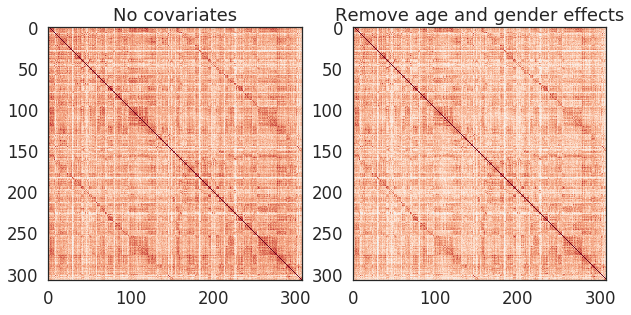

In [12]:
# Take a look at the two different correlation matrices
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(M, cmap='RdBu_r', vmin=-0.8, vmax=0.8)
ax[0].set_title('No covariates')
ax[1].imshow(M_age_male, cmap='RdBu_r', vmin=-0.8, vmax=0.8)
ax[1].set_title('Remove age and gender effects')
plt.show()

## 2 Create a weighted graph

From our correlation matrix we're ready to make a graph!

A short sidenote on the `BrainNetwork` class. This is a very lightweight subclass of the [`Networkx.Graph`](https://networkx.github.io/documentation/stable/reference/classes/graph.html) class. This means that any methods you can use on a `Networkx.Graph` object can also be used on a `BrainNetwork` object, although the reverse is not true. We have **added** various methods that allow us to keep track of measures that have already been calculated. This is particularly useful later on when one is dealing with 1000 random graphs (or more!) and saves a lot of time.

Initialise a weighted graph `G` from the correlation matrix `M`. The `parcellation` and `centroids` arguments are used to label nodes with names and coordinates respectively.

`G` can be created from a pandas data frame (as we're doing here), a numpy array, or a networkx graph. So this is a great place to jump in from another processing package if you have a preferred way of creating your correlation matrix.

The `scn.BrainNetwork` options `parcellation` and `centroids` are optional, but recommended. If you don't give `scn.BrainNetwork` the names of your regions or the coordinates of each region, there will be some graph measures that can't be calculated (for example euclidean distance) and the output might be somewhat harder to interpret (you won't have a nice mapping between the nodes back to your regional data).

In this section of the tutorial we'll just take the data with no covariates forward to help with readability) but a comparison of values with and without the age and gender covariates is at the very end of this notebook :)

In [13]:
G = scn.BrainNetwork(network=M, parcellation=names, centroids=centroids)

In [15]:
# Take a look at the information stored for the first node 
# of the graph we created 
G.nodes[0]

{'name': 'lh_bankssts_part1',
 'x': -56.40355,
 'y': -40.152663,
 'z': 1.708876,
 'centroids': array([-56.40355 , -40.152663,   1.708876])}

In [16]:
# Or you can see the weight (the correlation strength) 
# of the egde between nodes 0 and 1
G.edges[(0,1)]

{'weight': 0.579735609734101}

## 3 Threshold to create a binary graph

Next we'll threshold `G` at cost 10 to create a binary graph with 10% as many edges as the complete graph `G`.

Ordinarily when thresholding one takes the 10% of edges with the *highest* weight. However, this can sometimes leave a disconnected graph, which in the context of brain networks is not biologically plausible nor easily interpretable. Therefore, in order to ensure that the resulting graph is connected, we will calculate a **minimum spanning tree** first. A "tree" is the smallest possible graph where you can travel from every node to every other node. The minimum spanning tree builds that tree from the strongest available edges.

This calculation happens within the `BrainNetwork.threshold` method. If you want to omit the minimum spanning tree step, you can pass the argument `mst=False` to `G.threshold`.

The `threshold` method does not edit objects inplace.

In [17]:
G10 = G.threshold(10)

In [18]:
# Note that edges that still exist now have a weight of 1
G10.edges[(0,1)]

{'weight': 1}

In [19]:
# Some of these edges don't exist any more!
# (90% of them to be exact)
try:
    G10.edges[(0,50)]
except KeyError:
    print("This edge does not exist!")

This edge does not exist!


## 4 Calculate nodal measures

### 4.0 Calculate standard network measures

The `BrainNetwork` method `calculate_nodal_measures` computes and records the following nodal measures **by default**:

* `betweenness`: betweenness centrality
* `closeness`: closeness centrality
* `clustering`: clustering coefficient
* `degree`: number of edges from that node
* `module`: which module this node belongs to according to the louvain community detection algorithm (starting from 0)
* `participation_coefficient`: participation coefficient according to the partition defined above
* `shortest_path_length`: shortest path length from this node to any other in the network


Lets start by seeing the nodal attributes we already have. The useful method `report_nodal_measure` returns all these values in a DataFrame.

In [20]:
G10.report_nodal_measures().head()

,name,centroids,x,y,z
0,lh_bankssts_part1,"[-56.40355, -40.152663, 1.708876]",-56.4036,-40.1527,1.70888
1,lh_bankssts_part2,"[-53.140506, -49.843038, 8.264557]",-53.1405,-49.843,8.26456
2,lh_caudalanteriorcingulate_part1,"[-5.001684, 20.645903, 25.733446]",-5.00168,20.6459,25.7334
3,lh_caudalmiddlefrontal_part1,"[-33.265925, 20.200202, 45.347826]",-33.2659,20.2002,45.3478
4,lh_caudalmiddlefrontal_part2,"[-31.958115, 2.146597, 51.26911]",-31.9581,2.1466,51.2691


We can run `calculate_nodal_measures` to fill in a lot more information to that DataFrame.

This method takes around 6 seconds to run. Which isn't long but adds up when you're creating random graphs for comparison with your real network data. Therefore this `BrainNetwork` method will check to see if the measures already exist before it re-calculates them. If they're already there it will just move on to the next one.

You can re-calculate the nodal measures by setting the option `force=True`.

In [21]:
%%timeit -n 1
G10.calculate_nodal_measures()

The slowest run took 8579.36 times longer than the fastest. This could mean that an intermediate result is being cached.
1.25 s ± 3.04 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
%%timeit -n 1
G10.calculate_nodal_measures()

The slowest run took 26.59 times longer than the fastest. This could mean that an intermediate result is being cached.
5.32 ms ± 8.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
%%timeit -n 1
G10.calculate_nodal_measures(force=True)

7.94 s ± 630 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The `calculate_nodal_measures` method assigns these calculated values to the `BrainNetwork` graph.

We can look at a nice summary using `report_nodal_measures` which outputs a pandas DataFrame.

In [24]:
G10.report_nodal_measures().head()

,name,centroids,betweenness,closeness,clustering,degree,module,participation_coefficient,shortest_path_length,x,y,z
0,lh_bankssts_part1,"[-56.40355, -40.152663, 1.708876]",0.00824713,0.495961,0.3358,47,0,0.717067,2.00974,-56.4036,-40.1527,1.70888
1,lh_bankssts_part2,"[-53.140506, -49.843038, 8.264557]",0.0124798,0.507438,0.278788,55,0,0.809587,1.96429,-53.1405,-49.843,8.26456
2,lh_caudalanteriorcingulate_part1,"[-5.001684, 20.645903, 25.733446]",0,0.336254,1,2,1,0.75,2.96429,-5.00168,20.6459,25.7334
3,lh_caudalmiddlefrontal_part1,"[-33.265925, 20.200202, 45.347826]",0.0120765,0.525685,0.383485,83,2,0.459864,1.8961,-33.2659,20.2002,45.3478
4,lh_caudalmiddlefrontal_part2,"[-31.958115, 2.146597, 51.26911]",0.0292617,0.549195,0.293617,95,2,0.688753,1.81494,-31.9581,2.1466,51.2691


### 4.1 Calculate spatial nodal measures

The method `calculate_spatial_measures` calculates nodal and edge values that relate to the euclidean distances between nodes. They can only be calculated if the `centroids` file is available.

The edge attributes are:

* `euclidean`: the distance between two nodes (in the units given in the `centroids` file, likely mm).
* `interhem`: whether the node connects regions in two different hemispheres (`1` if yes, `0` if no).

The nodal measures are:

* `average_dist`: the average distance across all edges connected to that node
* `total_dist`: the total distance of all edges connected to that node
* `hemisphere`: whether the node is in the left (`L`) or right (`R`) hemisphere
* `interhem`: number of interhemispheric edges from that node
* `interhem_proportion`: proportion of interhemispheric edges from that node


In [25]:
G10.calculate_spatial_measures()

In [26]:
# Lets take a look at all the nodal measures again 
G10.report_nodal_measures().head()

,name,centroids,average_dist,betweenness,closeness,clustering,degree,hemisphere,interhem,interhem_proportion,module,participation_coefficient,shortest_path_length,total_dist,x,y,z
0,lh_bankssts_part1,"[-56.40355, -40.152663, 1.708876]",63.6244,0.00824713,0.495961,0.3358,47,L,12,0.255319,0,0.717067,2.00974,2990.35,-56.4036,-40.1527,1.70888
1,lh_bankssts_part2,"[-53.140506, -49.843038, 8.264557]",63.21,0.0124798,0.507438,0.278788,55,L,14,0.254545,0,0.809587,1.96429,3476.55,-53.1405,-49.843,8.26456
2,lh_caudalanteriorcingulate_part1,"[-5.001684, 20.645903, 25.733446]",24.6361,0,0.336254,1,2,L,0,0,1,0.75,2.96429,49.2723,-5.00168,20.6459,25.7334
3,lh_caudalmiddlefrontal_part1,"[-33.265925, 20.200202, 45.347826]",60.8921,0.0120765,0.525685,0.383485,83,L,39,0.46988,2,0.459864,1.8961,5054.04,-33.2659,20.2002,45.3478
4,lh_caudalmiddlefrontal_part2,"[-31.958115, 2.146597, 51.26911]",63.1913,0.0292617,0.549195,0.293617,95,L,37,0.389474,2,0.688753,1.81494,6003.17,-31.9581,2.1466,51.2691


### 4.2 Add your own measures

It's quite likely that you may want to attribute additional values to each node. For example, in their paper in 2016, Whitaker, Vertes and colleagues correlated the cross sectional decrease in cortical thickness between ages 14 and 24 for each region with its degree. They showed that the hubs - the best connected regions - changed the most in this late adolescent age range.

As we're using this data 

We can also add measures as one might normally add nodal attributes to a networkx graph

In [27]:
dCT = df.loc[:, ['age_scan'] + names].corr().iloc[0, 1:]

dCT.head()

lh_bankssts_part1                  -0.249272
lh_bankssts_part2                  -0.253286
lh_caudalanteriorcingulate_part1   -0.116030
lh_caudalmiddlefrontal_part1       -0.297439
lh_caudalmiddlefrontal_part2       -0.229561
Name: age_scan, dtype: float64

In [28]:
nx.set_node_attributes(G10, name="dCT", values={ node: dCT[G10._node[node]['name']] for node in G10.nodes()})

These show up in our DataFrame too

In [29]:
nodal_df = G10.report_nodal_measures(columns=['name', 'degree', 'dCT'])
nodal_df.head()

,name,dCT,degree
0,lh_bankssts_part1,-0.249272,47
1,lh_bankssts_part2,-0.253286,55
2,lh_caudalanteriorcingulate_part1,-0.11603,2
3,lh_caudalmiddlefrontal_part1,-0.297439,83
4,lh_caudalmiddlefrontal_part2,-0.229561,95


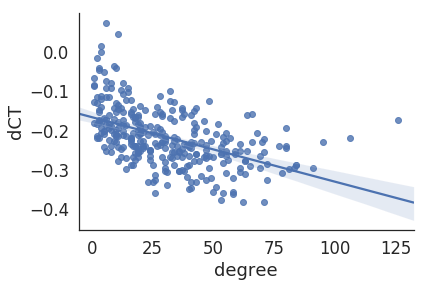

In [30]:
nodal_df = G10.report_nodal_measures(columns=['degree', 'dCT'])
sns.regplot(data=nodal_df, y='dCT', x='degree')
sns.despine()

### Calculate Global measures

These are attributes of the WHOLE GRAPH.

In [31]:
G10.calculate_global_measures()

{'average_clustering': 0.4498887255891581,
 'average_shortest_path_length': 2.376242649858285,
 'assortativity': 0.09076922258276784,
 'modularity': 0.3828553111606414,
 'efficiency': 0.47983958611582744}

In [32]:
G10.rich_club()

{0: 0.1000042302973899,
 1: 0.10322820361506349,
 2: 0.10724360724360725,
 3: 0.11203913614127192,
 4: 0.11784154867368314,
 5: 0.12239789196310935,
 6: 0.12797536481162958,
 7: 0.13189883627145985,
 8: 0.13682019726721564,
 9: 0.14106907585168454,
 10: 0.1473701675792268,
 11: 0.15494805517143567,
 12: 0.1588349657019185,
 13: 0.16688298918387415,
 14: 0.17194570135746606,
 15: 0.17401868375853546,
 16: 0.18359535201640464,
 17: 0.1902830097556264,
 18: 0.19874650367761318,
 19: 0.21160370306480364,
 20: 0.22321260435628648,
 21: 0.2290311986863711,
 22: 0.233578131374949,
 23: 0.23619909502262443,
 24: 0.24562322310339668,
 25: 0.2505434782608696,
 26: 0.25957268537913697,
 27: 0.265074939003137,
 28: 0.27332028701891714,
 29: 0.28520770010131713,
 30: 0.2987012987012987,
 31: 0.30135055783910747,
 32: 0.3102112235970504,
 33: 0.3190723710515794,
 34: 0.3334806955496611,
 35: 0.34031982611395745,
 36: 0.3476230191826522,
 37: 0.35847647498132934,
 38: 0.3690909090909091,
 39: 0.37414

## Create a GraphBundle

The `GraphBundle` object is the `scona` way to handle across-network comparisons. What is it? Essentially it's a python dictionary with `BrainNetwork` objects as values.

In [33]:
brain_bundle = scn.GraphBundle([G10], ['NSPN_cost10'])

This creates a dictionary-like object with BrainNetwork `H` keyed by `'NSPN_cost=10'`

In [34]:
brain_bundle

{'NSPN_cost10': <scona.classes.BrainNetwork at 0x7f0afb857a58>}

Now add a series of random graphs created by edge swap randomisation of G10 (keyed by `'NSPN_cost10'`).

The `create_random_graphs` method of the `GraphBundle` class takes in a **real** network (in our case `G10`) and creates a number (`10` in the example below) of random graphs. The output is a dictionary of all these graphs. The original one has the name you gave it (here: `"NSPN_cost10"`) and the random graphs have a suffix of `_Ri` where `i` is an integer counter starting at `0`.

What's pretty cool is that this function again saves the work you've done before. So if you generate a few random graphs and save them to the `brain_bundle` dictionary and then later want to add some more, the `create_random_graphs` method will recognise that there are some random graphs there already and append the new ones to the `brain_bundle`. The index for these additional random graphs will start counting from where the original run left off.


KW: DO A TIMEIT FUN DEMO HERE.

In [35]:
# Note that 10 is not usually a sufficient number of random graphs to do meaningful analysis,
# it is used here for time considerations
brain_bundle.create_random_graphs('NSPN_cost10', 5)

        Creating 5 random graphs - may take a little while


In [36]:
brain_bundle

{'NSPN_cost10': <scona.classes.BrainNetwork at 0x7f0afb857a58>,
 'NSPN_cost10_R0': <scona.classes.BrainNetwork at 0x7f0af20e0828>,
 'NSPN_cost10_R1': <scona.classes.BrainNetwork at 0x7f0af96294a8>,
 'NSPN_cost10_R2': <scona.classes.BrainNetwork at 0x7f0af20c8ef0>,
 'NSPN_cost10_R3': <scona.classes.BrainNetwork at 0x7f0af20c89b0>,
 'NSPN_cost10_R4': <scona.classes.BrainNetwork at 0x7f0af20c8d30>}

### Report on a GraphBundle

The following method will calculate global measures (if they have not already been calculated) for all of the graphs in `brain_bundle` and report the results in a DataFrame. We can do the same for rich club coefficients below.

In [37]:
brain_bundle.report_global_measures()

,assortativity,average_clustering,average_shortest_path_length,efficiency,modularity
NSPN_cost10,0.090769,0.449889,2.376243,0.479840,0.382855
NSPN_cost10_R0,-0.080689,0.226794,2.086848,0.519140,0.127894
NSPN_cost10_R1,-0.101128,0.229075,2.085431,0.519479,0.127006
NSPN_cost10_R2,-0.084430,0.220700,2.087144,0.519049,0.125902
NSPN_cost10_R3,-0.085280,0.233040,2.083802,0.519632,0.132009
NSPN_cost10_R4,-0.077542,0.229783,2.092665,0.518340,0.124864


In [38]:
rich_club_df = brain_bundle.report_rich_club()
rich_club_df.iloc[55:65, :]

,NSPN_cost10,NSPN_cost10_R0,NSPN_cost10_R1,NSPN_cost10_R2,NSPN_cost10_R3,NSPN_cost10_R4
55,0.566783,0.485482,0.465738,0.476190,0.511034,0.487805
56,0.574390,0.484146,0.470732,0.482927,0.512195,0.490244
57,0.578205,0.487179,0.470513,0.484615,0.514103,0.494872
58,0.599099,0.500000,0.478979,0.493994,0.533033,0.509009
59,0.606723,0.517647,0.485714,0.499160,0.529412,0.515966
60,0.606723,0.517647,0.485714,0.499160,0.529412,0.515966
61,0.615054,0.548387,0.503226,0.520430,0.548387,0.544086
62,0.625287,0.554023,0.494253,0.521839,0.549425,0.551724
63,0.652422,0.581197,0.498575,0.521368,0.561254,0.586895
64,0.653333,0.600000,0.516667,0.546667,0.563333,0.590000


In [39]:
calc_closeness = lambda x: x.calculate_nodal_measures(measure_list=["closeness"])
report_closeness = lambda x: x.report_nodal_measures(columns=["name", "closeness"])

brain_bundle.apply(graph_function=calc_closeness)
closeness_dict = brain_bundle.apply(graph_function=report_closeness)

for graph_key, closeness_df in closeness_dict.items():
    print(closeness_df.head())

                               name closeness
0                 lh_bankssts_part1  0.495961
1                 lh_bankssts_part2  0.507438
2  lh_caudalanteriorcingulate_part1  0.336254
3      lh_caudalmiddlefrontal_part1  0.525685
4      lh_caudalmiddlefrontal_part2  0.549195
                               name closeness
0                 lh_bankssts_part1  0.522998
1                 lh_bankssts_part2  0.539543
2  lh_caudalanteriorcingulate_part1  0.364608
3      lh_caudalmiddlefrontal_part1  0.570632
4      lh_caudalmiddlefrontal_part2  0.582543
                               name closeness
0                 lh_bankssts_part1  0.522998
1                 lh_bankssts_part2  0.532986
2  lh_caudalanteriorcingulate_part1  0.357809
3      lh_caudalmiddlefrontal_part1  0.569573
4      lh_caudalmiddlefrontal_part2  0.577068
                               name closeness
0                 lh_bankssts_part1  0.528399
1                 lh_bankssts_part2  0.532986
2  lh_caudalanteriorcingulate_part

In [40]:
calc_degree = lambda x: x.calculate_nodal_measures(measure_list=["degree"])
report_degree = lambda x: x.report_nodal_measures(columns=["name", "degree"])

brain_bundle.apply(graph_function=calc_degree)
degree_dict = brain_bundle.apply(graph_function=report_degree)

for graph_key, degree_df in degree_dict.items():
    print(degree_dict["NSPN_cost10"].head() == degree_df.head())

   name  degree
0  True    True
1  True    True
2  True    True
3  True    True
4  True    True
   name  degree
0  True    True
1  True    True
2  True    True
3  True    True
4  True    True
   name  degree
0  True    True
1  True    True
2  True    True
3  True    True
4  True    True
   name  degree
0  True    True
1  True    True
2  True    True
3  True    True
4  True    True
   name  degree
0  True    True
1  True    True
2  True    True
3  True    True
4  True    True
   name  degree
0  True    True
1  True    True
2  True    True
3  True    True
4  True    True


61.30000000000001

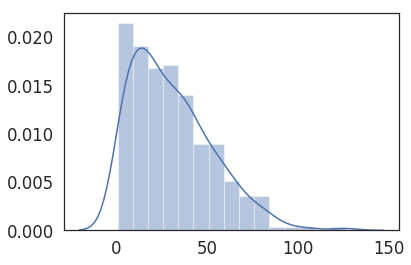

In [41]:
degree = G10.report_nodal_measures(columns=["degree"])
sns.distplot(degree)
np.percentile(degree, 90)